## Library

In [134]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
from scipy import stats
from pprint import pprint

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Variables (customize these)

In [135]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Wildeford'                         # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)


# Variable sets - definitely change these!
if USE_NUMBERS == 'Cotra2020':
    initial_gdp = 21 * trillion                    # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)
    
    tai_flop_size = distributed_lognorm([[25,35],  # Lifetime anchor
                                         [26.5,40.7],  # Small NN anchor
                                         [28.4,39.5],  # Genome anchor
                                         [28.1,43.5],  # Medium NN anchor
                                         [30.3,46.5],  # Long NN anchor
                                         [34.3,46.9],  # Evolution anchor
                                         [60,70]], # No path anchor
                                        [0.052,0.21,0.11,0.312,0.155,0.1,0.07]) # Relative weights
    # 90% CI, it takes 10^X FLOPs to run a transformative AI at inference.
    # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day,
    # or a total of about 10^20 operations
    
    algo_doubling_rate_max = norm(3.5, 3.5)        # 90% CI, algorithms get twice as efficient every X years (maximum)
    algo_doubling_rate_min = norm(2, 2)            # 90% CI, algorithms get twice as efficient every X years (minimum)
    min_reduction = norm(2, 2)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(5, 5)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17, 17)        # 90% CI, as of today, we can buy 10^X FLOPs per $
    flops_halving_rate = lognorm(2.5, 2.5)         # 90% CI, the cost of FLOPs per $ halves every X years
    max_flops_per_dollar = norm(24, 24)            # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    initial_pay = norm(8.7, 8.7)                       # 90% CI, as of today the maximum we would pay for TAI is $10^X
    gdp_growth = norm(1.03, 1.03)                  # 90% CI, GDP will increase by a factor of X each year
    max_gdp_frac = norm(0.01, 0.01)                # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    p_willingness_ramp = 0                         # What is the probability that, if we were close to TAI, we would suddenly ramp up spending?
    willingness_ramp = norm(1, 1)                  # 90% CI, if we are X% of the spend needed to acheive TAI, we will instantly jump to TAI
    willingness_spend_horizon = 1                  # How many years are we willing to consider spending to make TAI?
    spend_doubling_time = norm(2.5, 2.5)           # 90% CI, our willingness to spend on TAI doubles every X years
    initial_chance_of_nonscaling_issue = 0         # What is the chance there will be a non-scaling issue if TAI is feasible in `CURRENT_YEAR`?
    final_chance_of_nonscaling_issue = 0           # What is the chance there will be a non-scaling issue if TAI is feasible only by `nonscaling_issue_bottom_year` (see below)?
    nonscaling_issue_bottom_year = 0               # What year will will the chance of a non-scaling issue bottom out at (reaching `final_chance_of_nonscaling_issue`)?
    nonscaling_delay = norm(0, 0)                  # 90% CI, conditional on a delay, how many additional years will TAI be delayed due to issues unrelated to scaling to an adequate number of FLOPs (e.g., collecting the relevant training data)?

elif USE_NUMBERS == 'Cotra2022':
    initial_gdp = 21 * trillion
    tai_flop_size = distributed_lognorm([[25,35],  # Lifetime anchor
                                         [25.7,37.6],  # GPT-N anchor
                                         [26.5,40.7],  # Small NN anchor
                                         [28.4,39.5],  # Genome anchor
                                         [28.1,43.5],  # Medium NN anchor
                                         [30.3,46.5],  # Long NN anchor
                                         [34.3,46.9],  # Evolution anchor
                                         [60,70]], # No path anchor
                                        [0.1,0.2,0.3,0.1,0.12,0.1,0.05,0.03]) # Relative weights
    algo_doubling_rate_max = norm(3.5, 3.5)
    algo_doubling_rate_min = norm(2, 2)
    min_reduction = norm(2, 2)
    max_reduction = norm(5, 5)
    initial_flops_per_dollar = norm(18, 18)
    flops_halving_rate = norm(2.6, 3)
    max_flops_per_dollar = norm(24, 24)
    initial_pay = norm(8.7, 8.7)
    gdp_growth = norm(1.03, 1.03)
    max_gdp_frac = norm(0.01, 0.01)
    p_willingness_ramp = 0
    willingness_ramp = norm(1, 1)
    willingness_spend_horizon = 1
    spend_doubling_time = norm(2.5, 2.5)
    initial_chance_of_nonscaling_issue = 0
    final_chance_of_nonscaling_issue = 0
    nonscaling_issue_bottom_year = 0
    nonscaling_delay = norm(0, 0)
    
elif USE_NUMBERS == 'Wildeford':
    initial_gdp = 21 * trillion
    tai_flop_size = log_tdist(26, 41, 5) #log_tdist(27, 42, 5)
    min_reduction = norm(1, 3)
    max_reduction = norm(4, 8)
    algo_doubling_rate_max = norm(1.5, 4.5)
    algo_doubling_rate_min = norm_lclip(1, 3)
    initial_flops_per_dollar = lognorm(17.5, 18.5)
    flops_halving_rate = lognorm(2, 5)
    max_flops_per_dollar = norm(22, 27)
    initial_pay = distributed_lognorm([[6,7],[7,8]],[0.9,0.1])
    gdp_growth = norm(1.015, 1.035)
    max_gdp_frac = lognorm_lclip(0.00006, 0.002)
    p_willingness_ramp = 0.1
    willingness_ramp = norm(0.3, 0.9)
    willingness_spend_horizon = 10
    spend_doubling_time = lognorm_lclip(0.5, 2.75)
    initial_chance_of_nonscaling_issue = 0.9
    final_chance_of_nonscaling_issue = 0.1
    nonscaling_issue_bottom_year = 2050
    nonscaling_delay = lognorm(2, 20)
    
elif USE_NUMBERS == 'Kokotajlo':
    initial_gdp = 21 * trillion
    tai_flop_size = lognorm(24, 39)
    algo_doubling_rate_max = norm(1, 1)
    algo_doubling_rate_min = norm(1, 1)
    min_reduction = norm(2, 2)
    max_reduction = norm(5, 5)
    initial_flops_per_dollar = norm(18, 18)
    flops_halving_rate = norm(2.6, 3)
    max_flops_per_dollar = norm(24, 24)
    initial_pay = norm(8.7, 8.7)
    gdp_growth = norm(1.03, 1.03)
    max_gdp_frac = norm(0.01, 0.01)
    p_willingness_ramp = 1
    willingness_ramp = norm(0.1, 0.1)
    willingness_spend_horizon = 1
    spend_doubling_time = norm(2.5, 2.5)
    initial_chance_of_nonscaling_issue = 0
    final_chance_of_nonscaling_issue = 0
    nonscaling_issue_bottom_year = 0
    nonscaling_delay = norm(0, 0)
    
else:
    raise ValueError


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)

def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 700:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)

def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)

def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 700:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 700:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def p_nonscaling_delay(initial_p, final_p, year, max_year):
    initial_p = initial_p - final_p
    p_ = initial_p - (initial_p * ((year - CURRENT_YEAR) / (max_year - CURRENT_YEAR))) + final_p
    return final_p if p_ < final_p else p_

def p_rapid_recursive_self_improvement(flops_needed_for_tai, flops_we_have, base_p, curve_steepness, curve_inflection):
    if flops_we_have > 10 ** 250:
        return base_p  # Handle overflow error
    if flops_needed_for_tai > 10 ** 250:
        ratio = int(flops_we_have) // int(flops_needed_for_tai)
    else:
        ratio = flops_we_have / flops_needed_for_tai 
    return base_p / (1 + math.exp(-curve_steepness * (ratio - curve_inflection)))

    
# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')


Loaded


{1: 19.58408793901293,
 5: 23.98887698875383,
 10: 26.20171663620224,
 20: 28.447939615064723,
 30: 30.08348922032613,
 40: 31.40710065479599,
 50: 32.70602582193103,
 60: 34.01064185167737,
 70: 35.57955335246845,
 80: 37.4898547596466,
 90: 40.79960136011882,
 95: 44.4817630064501,
 99: 54.6016250566743}


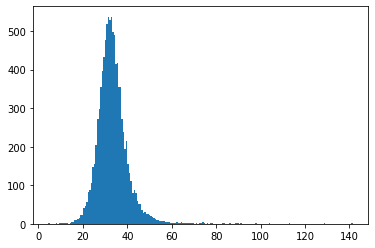

In [136]:
initial_flop_size_s = [sample(tai_flop_size) for s in range(10000)]
initial_flops_p = get_percentiles(initial_flop_size_s)
plt.hist(initial_flop_size_s, bins = 200)
pprint(initial_flops_p)

{1: 24.436430082383733,
 5: 26.632874357283242,
 10: 27.963971464387107,
 20: 29.667678831476653,
 30: 31.009919036380143,
 40: 32.2360857706269,
 50: 33.4815470493389,
 60: 34.71307210185957,
 70: 36.172001833429306,
 80: 38.048541671710844,
 90: 40.72977101171348,
 95: 42.95040775664991,
 99: 47.26102743496981}


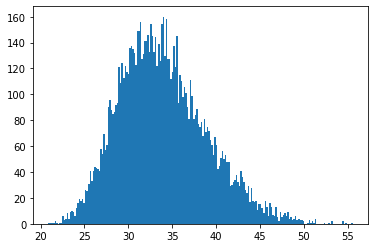

In [137]:
s_ = distributed_lognorm([[25,35],  # Lifetime anchor
                          [25.7,37.6],  # GPT-N anchor
                          [26.5,40.7],  # Small NN anchor
                          [28.4,39.5],  # Genome anchor
                          [28.1,43.5],  # Medium NN anchor
                          [30.3,46.5],  # Long NN anchor
                          [34.3,46.9],  # Evolution anchor
                          [60,70]], # No path anchor
                         [0.05,0.2,0.38,0,0.2,0.12,0.05,0]) # Relative weights
s_ = [sample(s_) for s in range(10000)]
p_ = get_percentiles(s_)
plt.hist(s_, bins = 200)
pprint(p_)

In [138]:
min_reduction_p = get_percentiles([sample(min_reduction) for s in range(1000)], reverse=True)
min_reduction_p

{99: 0.5659087687025807,
 95: 0.9465958084600281,
 90: 1.1964888787786123,
 80: 1.4722399453919917,
 70: 1.645443075326147,
 60: 1.8195937574854222,
 50: 1.9607121525411078,
 40: 2.1299848030586452,
 30: 2.3147948179344926,
 20: 2.541693271450441,
 10: 2.7877657604222996,
 5: 3.0548386377621437,
 1: 3.473754465668385}

In [139]:
max_reduction_p = get_percentiles([sample(max_reduction) for s in range(1000)], reverse=True)
max_reduction_p

{99: 2.907933141184328,
 95: 4.002165997196456,
 90: 4.403579488708895,
 80: 4.993883235879773,
 70: 5.3804175552557645,
 60: 5.717554738868001,
 50: 6.011020710947271,
 40: 6.373461519998034,
 30: 6.678460588929094,
 20: 7.034359309621955,
 10: 7.549873854940414,
 5: 7.966138864792238,
 1: 8.922115076751933}

In [140]:
algo_doubling_rate_min_p = get_percentiles([sample(algo_doubling_rate_min) for s in range(1000)], reverse=True)
algo_doubling_rate_min_p

{99: 1.0,
 95: 1.0,
 90: 1.2146767636713056,
 80: 1.496647143172761,
 70: 1.698873835330584,
 60: 1.8633972508973407,
 50: 2.0178127234516907,
 40: 2.16344619686668,
 30: 2.3426052458245983,
 20: 2.5162905449749426,
 10: 2.765434335738497,
 5: 2.9682770431141767,
 1: 3.393914972289679}

In [141]:
algo_doubling_rate_max_p = get_percentiles([sample(algo_doubling_rate_max) for s in range(1000)], reverse=True)
algo_doubling_rate_max_p

{99: 0.9610665784012118,
 95: 1.6518928283152758,
 90: 1.89779113637548,
 80: 2.2626024741129607,
 70: 2.536292004889506,
 60: 2.7799324929221942,
 50: 2.985034516724247,
 40: 3.2199279592945644,
 30: 3.5200095566590868,
 20: 3.8167678936411997,
 10: 4.2263322758298525,
 5: 4.593940229823316,
 1: 5.046789026097568}

In [142]:
initial_flops_per_dollar_p = get_percentiles([sample(initial_flops_per_dollar) for s in range(1000)])
initial_flops_per_dollar_p

{1: 17.337894320689358,
 5: 17.531197161441042,
 10: 17.612805093823564,
 20: 17.737329376490113,
 30: 17.856056796570275,
 40: 17.92515951423381,
 50: 18.006297261936524,
 60: 18.07137284858416,
 70: 18.152303135586898,
 80: 18.24257767593634,
 90: 18.377825339397102,
 95: 18.50185118780027,
 99: 18.784741301996046}

In [143]:
flops_halving_rate_p = get_percentiles([sample(flops_halving_rate) for s in range(1000)], reverse=True)
flops_halving_rate_p

{99: 1.6146498697963474,
 95: 1.969520614796657,
 90: 2.2294072133585625,
 80: 2.5002663354565886,
 70: 2.7505678326173846,
 60: 2.97510275687621,
 50: 3.194210924037157,
 40: 3.4522044611805387,
 30: 3.7418897605648795,
 20: 4.092661381136174,
 10: 4.5564285452919355,
 5: 4.97893527484028,
 1: 6.47937861603525}

In [144]:
max_flops_per_dollar_p = get_percentiles([sample(max_flops_per_dollar) for s in range(1000)])
max_flops_per_dollar_p

{1: 21.125364198537216,
 5: 22.10230647292749,
 10: 22.62672675396996,
 20: 23.277849093447298,
 30: 23.71205880156277,
 40: 24.119790166354523,
 50: 24.57021916957325,
 60: 24.96373377804054,
 70: 25.39266064849272,
 80: 25.84086198131711,
 90: 26.518196714959714,
 95: 27.099124868688328,
 99: 28.264794631416404}

In [145]:
initial_pay_p = get_percentiles([sample(initial_pay) for s in range(1000)])
initial_pay_p

{1: 5.782087302882645,
 5: 6.01337724885793,
 10: 6.114316807090222,
 20: 6.251062534763765,
 30: 6.348115947092145,
 40: 6.434301942036593,
 50: 6.52785763515036,
 60: 6.617131227952075,
 70: 6.709964230555146,
 80: 6.847042260150555,
 90: 7.1844191523234615,
 95: 7.508444787372242,
 99: 7.9727955266283725}

In [146]:
gdp_growth_p = get_percentiles([sample(gdp_growth) for s in range(1000)])
gdp_growth_p

{1: 1.0103439994727537,
 5: 1.0151088722402524,
 10: 1.0170398559214815,
 20: 1.0201281361123296,
 30: 1.0218684606991424,
 40: 1.0230863915218178,
 50: 1.0247205022155206,
 60: 1.026614803613279,
 70: 1.0284318371113799,
 80: 1.0303699648691125,
 90: 1.0330127448366566,
 95: 1.03492154059269,
 99: 1.0399390437576954}

In [147]:
max_gdp_frac_p = get_percentiles([sample(max_gdp_frac) for s in range(1000)])
max_gdp_frac_p

{1: 6e-05,
 5: 6.404641823414351e-05,
 10: 9.144465648223767e-05,
 20: 0.00014680637755776736,
 30: 0.00020770658885235606,
 40: 0.00028078715073233537,
 50: 0.0003612986310019754,
 60: 0.000470236449210846,
 70: 0.0006063473648585616,
 80: 0.00081888736694448,
 90: 0.0012689554319173207,
 95: 0.0018385834595963655,
 99: 0.0040510380836244}

In [148]:
willingness_ramp_p = get_percentiles([sample(willingness_ramp) for s in range(1000)])
willingness_ramp_p

{1: 0.2033334333957105,
 5: 0.30482589139965743,
 10: 0.36321216265912115,
 20: 0.45060996361132943,
 30: 0.5058775284808708,
 40: 0.5577703335102296,
 50: 0.5987926763635105,
 60: 0.6449785110212017,
 70: 0.6896101531657985,
 80: 0.754286264653235,
 90: 0.8314674690425276,
 95: 0.8968097493532607,
 99: 1.013169066213556}

In [149]:
spend_doubling_time_p = get_percentiles([sample(spend_doubling_time) for s in range(1000)], reverse=True)
spend_doubling_time_p

{99: 0.5,
 95: 0.5,
 90: 0.5818462853628567,
 80: 0.7466843598297449,
 70: 0.8904431743089527,
 60: 1.0385879927087478,
 50: 1.16277727924997,
 40: 1.3282367773508166,
 30: 1.5313115319501551,
 20: 1.8078158288828114,
 10: 2.2049194837115302,
 5: 2.7161069808344322,
 1: 3.641471338174542}

In [150]:
nonscaling_delay_p = get_percentiles([sample(nonscaling_delay) for s in range(1000)], reverse=True)
nonscaling_delay_p

{99: 1.1969894968626604,
 95: 2.015732816348722,
 90: 2.5241034322669016,
 80: 3.444331574364156,
 70: 4.377344528308449,
 60: 5.426946702419239,
 50: 6.563652682757141,
 40: 7.8875754710773665,
 30: 9.236230564549759,
 20: 11.584697677835198,
 10: 15.541884662730967,
 5: 20.440143874387537,
 1: 35.82666489405294}

## GDP Over Time

Text(0, 0.5, 'log GDP')

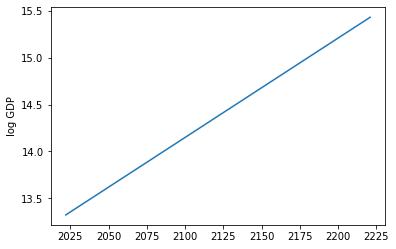

In [151]:
gdp_ = np.array([gdp(initial_gdp=initial_gdp,
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [152]:
for y in years:
    print('Year: {} - GDP log 2022$USD {} (~{})'.format(y,
                                                        np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                                        numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2023 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2024 - GDP log 2022$USD 13.3 (~10 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2033 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2034 - GDP log 2022$USD 13.4 (~10 trillion)
Year: 2035 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2036 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2037 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2038 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2039 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2040 - GDP log 2022$USD 13.5 (~10 trillion)
Year: 2041 - GDP log 2022$USD 13.5 (~10 trillion)


## Willingness to Pay Over Time

-
-
## 20 ##
Year: 2022 - willingness log 2022$USD per year 6.3 (~one million)
Year: 2023 - willingness log 2022$USD per year 6.4 (~one million)
Year: 2024 - willingness log 2022$USD per year 6.6 (~one million)
Year: 2025 - willingness log 2022$USD per year 6.7 (~one million)
Year: 2026 - willingness log 2022$USD per year 6.9 (~one million)
Year: 2027 - willingness log 2022$USD per year 7.1 (~10 million)
Year: 2028 - willingness log 2022$USD per year 7.2 (~10 million)
Year: 2029 - willingness log 2022$USD per year 7.4 (~10 million)
Year: 2030 - willingness log 2022$USD per year 7.6 (~10 million)
Year: 2031 - willingness log 2022$USD per year 7.7 (~10 million)
Year: 2032 - willingness log 2022$USD per year 7.9 (~10 million)
Year: 2033 - willingness log 2022$USD per year 8.1 (~100 million)
Year: 2034 - willingness log 2022$USD per year 8.2 (~100 million)
Year: 2035 - willingness log 2022$USD per year 8.4 (~100 million)
Year: 2036 - willingness log 2022$USD per year 8.5 (~100 million)
Yea

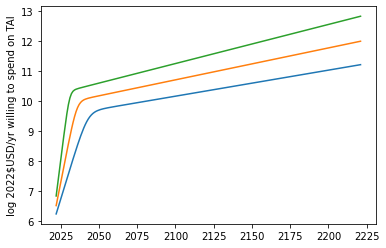

In [153]:
for p in [20, 50, 80]:
    print('-')
    print('-')
    print('## {} ##'.format(p))
    willingness = np.array([willingness_to_pay(initial_gdp=initial_gdp,
                                               gdp_growth=gdp_growth_p[p],
                                               initial_pay=10 ** initial_pay_p[p],
                                               spend_doubling_time=spend_doubling_time_p[p],
                                               max_gdp_frac=max_gdp_frac_p[p],
                                               year=(y - CURRENT_YEAR)) for y in years])
    for y in years:
        print('Year: {} - willingness log 2022$USD per year {} (~{})'.format(y,
                                                                             np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                                             numerize(np.log10(willingness[y - CURRENT_YEAR]))))


    plt.plot(years, np.log10(willingness))
plt.ylabel('log 2022$USD/yr willing to spend on TAI')
plt.show()


## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

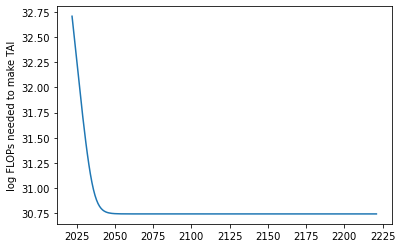

In [154]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                              algo_doubling_rate_max_p[GRAPH_P],
                                                              initial_flops_p[GRAPH_P]),
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [155]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} (~{})'.format(y,
                                                                np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                                numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 32.7 (~100 nonillion)
Year: 2023 - log FLOPs needed for TAI 32.6 (~100 nonillion)
Year: 2024 - log FLOPs needed for TAI 32.4 (~100 nonillion)
Year: 2025 - log FLOPs needed for TAI 32.3 (~100 nonillion)
Year: 2026 - log FLOPs needed for TAI 32.1 (~100 nonillion)
Year: 2027 - log FLOPs needed for TAI 32.0 (~10 nonillion)
Year: 2028 - log FLOPs needed for TAI 31.8 (~10 nonillion)
Year: 2029 - log FLOPs needed for TAI 31.7 (~10 nonillion)
Year: 2030 - log FLOPs needed for TAI 31.6 (~10 nonillion)
Year: 2031 - log FLOPs needed for TAI 31.5 (~10 nonillion)
Year: 2032 - log FLOPs needed for TAI 31.3 (~10 nonillion)
Year: 2033 - log FLOPs needed for TAI 31.2 (~10 nonillion)
Year: 2034 - log FLOPs needed for TAI 31.1 (~10 nonillion)
Year: 2035 - log FLOPs needed for TAI 31.1 (~10 nonillion)
Year: 2036 - log FLOPs needed for TAI 31.0 (~one nonillion)
Year: 2037 - log FLOPs needed for TAI 30.9 (~one nonillion)
Year: 2038 - log FLOPs needed for TAI 30.9 (~one 

## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

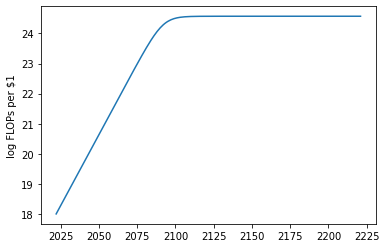

In [156]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [157]:
for y in years:
    print('Year: {} - log {} FLOPs per $ (~{})'.format(y,
                                                       np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 18.0 FLOPs per $ (~one quintillion)
Year: 2023 - log 18.1 FLOPs per $ (~one quintillion)
Year: 2024 - log 18.2 FLOPs per $ (~one quintillion)
Year: 2025 - log 18.3 FLOPs per $ (~one quintillion)
Year: 2026 - log 18.4 FLOPs per $ (~one quintillion)
Year: 2027 - log 18.5 FLOPs per $ (~one quintillion)
Year: 2028 - log 18.6 FLOPs per $ (~one quintillion)
Year: 2029 - log 18.7 FLOPs per $ (~one quintillion)
Year: 2030 - log 18.8 FLOPs per $ (~one quintillion)
Year: 2031 - log 18.9 FLOPs per $ (~one quintillion)
Year: 2032 - log 18.9 FLOPs per $ (~one quintillion)
Year: 2033 - log 19.0 FLOPs per $ (~10 quintillion)
Year: 2034 - log 19.1 FLOPs per $ (~10 quintillion)
Year: 2035 - log 19.2 FLOPs per $ (~10 quintillion)
Year: 2036 - log 19.3 FLOPs per $ (~10 quintillion)
Year: 2037 - log 19.4 FLOPs per $ (~10 quintillion)
Year: 2038 - log 19.5 FLOPs per $ (~10 quintillion)
Year: 2039 - log 19.6 FLOPs per $ (~10 quintillion)
Year: 2040 - log 19.7 FLOPs per $ (~10 quintillion)
Y

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

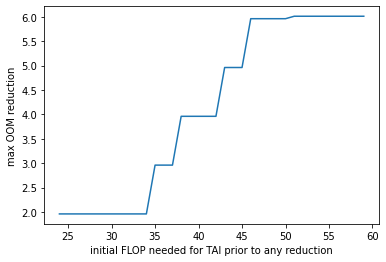

In [158]:
tai_sizes = range(24, 60)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')


In [159]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 round(possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                                  max_reduction_p[GRAPH_P],
                                                                                                  t), 2)))
          

TAI log FLOP 24 -> 1.96 OOM reductions possible
TAI log FLOP 25 -> 1.96 OOM reductions possible
TAI log FLOP 26 -> 1.96 OOM reductions possible
TAI log FLOP 27 -> 1.96 OOM reductions possible
TAI log FLOP 28 -> 1.96 OOM reductions possible
TAI log FLOP 29 -> 1.96 OOM reductions possible
TAI log FLOP 30 -> 1.96 OOM reductions possible
TAI log FLOP 31 -> 1.96 OOM reductions possible
TAI log FLOP 32 -> 1.96 OOM reductions possible
TAI log FLOP 33 -> 1.96 OOM reductions possible
TAI log FLOP 34 -> 1.96 OOM reductions possible
TAI log FLOP 35 -> 2.96 OOM reductions possible
TAI log FLOP 36 -> 2.96 OOM reductions possible
TAI log FLOP 37 -> 2.96 OOM reductions possible
TAI log FLOP 38 -> 3.96 OOM reductions possible
TAI log FLOP 39 -> 3.96 OOM reductions possible
TAI log FLOP 40 -> 3.96 OOM reductions possible
TAI log FLOP 41 -> 3.96 OOM reductions possible
TAI log FLOP 42 -> 3.96 OOM reductions possible
TAI log FLOP 43 -> 4.96 OOM reductions possible
TAI log FLOP 44 -> 4.96 OOM reductions p

## Halving time (years) of compute requirements

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

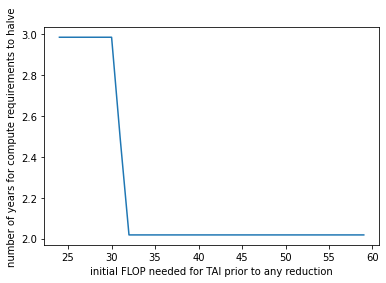

In [160]:
tai_sizes = range(24, 60)
flops_per_dollar_ = np.array([algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P], algo_doubling_rate_max_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('number of years for compute requirements to halve')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')


In [161]:
for t in tai_sizes:
    print('TAI log FLOP {} -> algo doubling rate {}yrs'.format(t,
                                                               round(algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                                                     algo_doubling_rate_max_p[GRAPH_P],
                                                                                     t), 2)))


TAI log FLOP 24 -> algo doubling rate 2.99yrs
TAI log FLOP 25 -> algo doubling rate 2.99yrs
TAI log FLOP 26 -> algo doubling rate 2.99yrs
TAI log FLOP 27 -> algo doubling rate 2.99yrs
TAI log FLOP 28 -> algo doubling rate 2.99yrs
TAI log FLOP 29 -> algo doubling rate 2.99yrs
TAI log FLOP 30 -> algo doubling rate 2.99yrs
TAI log FLOP 31 -> algo doubling rate 2.49yrs
TAI log FLOP 32 -> algo doubling rate 2.02yrs
TAI log FLOP 33 -> algo doubling rate 2.02yrs
TAI log FLOP 34 -> algo doubling rate 2.02yrs
TAI log FLOP 35 -> algo doubling rate 2.02yrs
TAI log FLOP 36 -> algo doubling rate 2.02yrs
TAI log FLOP 37 -> algo doubling rate 2.02yrs
TAI log FLOP 38 -> algo doubling rate 2.02yrs
TAI log FLOP 39 -> algo doubling rate 2.02yrs
TAI log FLOP 40 -> algo doubling rate 2.02yrs
TAI log FLOP 41 -> algo doubling rate 2.02yrs
TAI log FLOP 42 -> algo doubling rate 2.02yrs
TAI log FLOP 43 -> algo doubling rate 2.02yrs
TAI log FLOP 44 -> algo doubling rate 2.02yrs
TAI log FLOP 45 -> algo doubling r

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

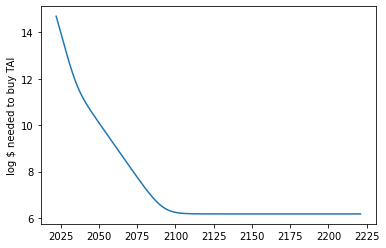

In [162]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                                        algo_doubling_rate_max_p[GRAPH_P],
                                                                        initial_flops_p[GRAPH_P]),
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [163]:
for y in years:
    print('Year: {} - log $ {} to buy TAI (~{})'.format(y,
                                                        np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                        numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 14.7 to buy TAI (~100 trillion)
Year: 2023 - log $ 14.5 to buy TAI (~100 trillion)
Year: 2024 - log $ 14.2 to buy TAI (~100 trillion)
Year: 2025 - log $ 14.0 to buy TAI (~10 trillion)
Year: 2026 - log $ 13.7 to buy TAI (~10 trillion)
Year: 2027 - log $ 13.5 to buy TAI (~10 trillion)
Year: 2028 - log $ 13.3 to buy TAI (~10 trillion)
Year: 2029 - log $ 13.0 to buy TAI (~10 trillion)
Year: 2030 - log $ 12.8 to buy TAI (~one trillion)
Year: 2031 - log $ 12.6 to buy TAI (~one trillion)
Year: 2032 - log $ 12.4 to buy TAI (~one trillion)
Year: 2033 - log $ 12.2 to buy TAI (~one trillion)
Year: 2034 - log $ 12.0 to buy TAI (~one trillion)
Year: 2035 - log $ 11.8 to buy TAI (~100 billion)
Year: 2036 - log $ 11.7 to buy TAI (~100 billion)
Year: 2037 - log $ 11.5 to buy TAI (~100 billion)
Year: 2038 - log $ 11.4 to buy TAI (~100 billion)
Year: 2039 - log $ 11.2 to buy TAI (~100 billion)
Year: 2040 - log $ 11.1 to buy TAI (~100 billion)
Year: 2041 - log $ 11.0 to buy TAI (~100 b

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

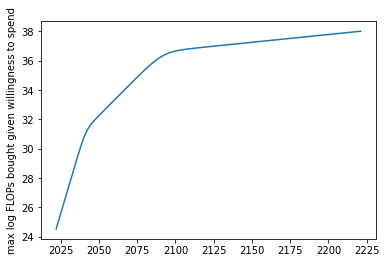

In [164]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=initial_gdp,
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [165]:
for y in years:
    print('Year: {} - max log FLOPs {} (~{})'.format(y,
                                                     np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                     numerize(np.log10(flops_at_max_[y - CURRENT_YEAR]))))

Year: 2022 - max log FLOPs 24.5 (~one septillion)
Year: 2023 - max log FLOPs 24.9 (~one septillion)
Year: 2024 - max log FLOPs 25.2 (~10 septillion)
Year: 2025 - max log FLOPs 25.6 (~10 septillion)
Year: 2026 - max log FLOPs 25.9 (~10 septillion)
Year: 2027 - max log FLOPs 26.3 (~100 septillion)
Year: 2028 - max log FLOPs 26.7 (~100 septillion)
Year: 2029 - max log FLOPs 27.0 (~one octillion)
Year: 2030 - max log FLOPs 27.4 (~one octillion)
Year: 2031 - max log FLOPs 27.7 (~one octillion)
Year: 2032 - max log FLOPs 28.1 (~10 octillion)
Year: 2033 - max log FLOPs 28.4 (~10 octillion)
Year: 2034 - max log FLOPs 28.8 (~10 octillion)
Year: 2035 - max log FLOPs 29.1 (~100 octillion)
Year: 2036 - max log FLOPs 29.5 (~100 octillion)
Year: 2037 - max log FLOPs 29.8 (~100 octillion)
Year: 2038 - max log FLOPs 30.1 (~one nonillion)
Year: 2039 - max log FLOPs 30.4 (~one nonillion)
Year: 2040 - max log FLOPs 30.7 (~one nonillion)
Year: 2041 - max log FLOPs 31.0 (~one nonillion)
Year: 2042 - max lo

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

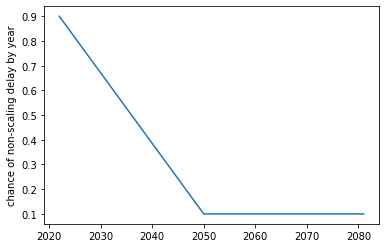

In [166]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                   final_chance_of_nonscaling_issue,
                                                   year=y,
                                                   max_year=nonscaling_issue_bottom_year) for y in years])

plt.plot(years[:60], p_nonscaling_delay_[:60])
plt.ylabel('chance of non-scaling delay by year')
# TODO: Make logistic?

In [167]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 90.0%
Year: 2023 - p(nonscaling delay) = 87.1%
Year: 2024 - p(nonscaling delay) = 84.3%
Year: 2025 - p(nonscaling delay) = 81.4%
Year: 2026 - p(nonscaling delay) = 78.6%
Year: 2027 - p(nonscaling delay) = 75.7%
Year: 2028 - p(nonscaling delay) = 72.9%
Year: 2029 - p(nonscaling delay) = 70.0%
Year: 2030 - p(nonscaling delay) = 67.1%
Year: 2031 - p(nonscaling delay) = 64.3%
Year: 2032 - p(nonscaling delay) = 61.4%
Year: 2033 - p(nonscaling delay) = 58.6%
Year: 2034 - p(nonscaling delay) = 55.7%
Year: 2035 - p(nonscaling delay) = 52.9%
Year: 2036 - p(nonscaling delay) = 50.0%
Year: 2037 - p(nonscaling delay) = 47.1%
Year: 2038 - p(nonscaling delay) = 44.3%
Year: 2039 - p(nonscaling delay) = 41.4%
Year: 2040 - p(nonscaling delay) = 38.6%
Year: 2041 - p(nonscaling delay) = 35.7%
Year: 2042 - p(nonscaling delay) = 32.9%
Year: 2043 - p(nonscaling delay) = 30.0%
Year: 2044 - p(nonscaling delay) = 27.1%
Year: 2045 - p(nonscaling delay) = 24.3%
Year: 2046 - p(n

## Run Model

It takes 31 log FLOPs (~10 nonillion) for transformative capabilities.
Every 2 years algorithms get 2x better, with 3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 7.0 log 2022$USD (~10 million) and this increases by 1x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.025x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 6 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.0 max log FLOP (one septillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 7.0 (one million) - 18.0 log FLOPS per $ (100 quadrillion)
Year: 2023 - 25.5 max log FLOP (10 septillion) available - TAI takes 30

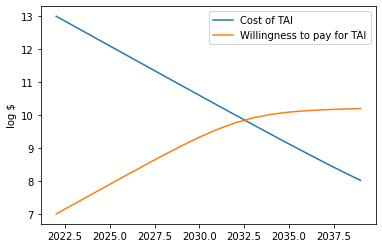

2039

In [212]:
def run_model(tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
              possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
              max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
              willingness_ramp_, spend_doubling_time_, initial_chance_of_nonscaling_issue_,
              final_chance_of_nonscaling_issue_, nonscaling_issue_bottom_year_,
              willingness_spend_horizon_, print_diagnostic):
    queue_tai_year = 99999
    plt.ioff()
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    if print_diagnostic:
        print('It takes {} log FLOPs (~{}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                    numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs (~{}) per 2022$USD. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs (~{}) per 2022$USD.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                               numerize(math.log10(initial_flops_per_dollar_)),
                                                                               np.round(flops_halving_rate_, 1),
                                                                               np.round(math.log10(max_flops_per_dollar_), 1),
                                                                               numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log 2022$USD (~{}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        if willingness_ramp_ < 1:
            print('In this simulation, if we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))
        else:
            print('In this simulation, there are no willingness ramp effects.')
        print('We are willing to spend over {} years to make TAI'.format(willingness_spend_horizon_))
            
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    for y in years:
        if not tai_created:
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200 or flops_needed_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                cost_of_tai_ = flops_needed_ // flops_per_dollar_
            else:
                cost_of_tai_ = flops_needed_ / flops_per_dollar_
            
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            if print_diagnostic:
                cost_of_tai_collector.append(cost_of_tai_)
                willingness_collector.append(willingness_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ > 10 ** 200:
                spend_tai_years = int(cost_of_tai_) // int(willingness_)
            else:
                spend_tai_years = cost_of_tai_ / willingness_
                
            if not is_nonscaling_issue and queue_tai_year < 99999 and print_diagnostic:
                print('-$- {}/{}'.format(y, queue_tai_year))
            if (cost_of_tai_ * willingness_ramp_ <= willingness_) or y >= queue_tai_year:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue_,
                                                             final_chance_of_nonscaling_issue_,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year_)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    return y
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            elif (not is_nonscaling_issue and willingness_spend_horizon_ > 1 and
                  spend_tai_years <= willingness_spend_horizon_ and y + math.ceil(spend_tai_years) < queue_tai_year):
                queue_tai_year = y + math.ceil(spend_tai_years)
                if print_diagnostic:
                    print('-$- We have enough spend to make TAI in {} years (in {}) if sustained.'.format(math.ceil(spend_tai_years),
                                                                                                          queue_tai_year))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        return MAX_YEAR + 1

    
run_model(tai_flop_size_=31,
          nonscaling_delay_=6,
          algo_doubling_rate_=2,
          possible_algo_reduction_=3,
          initial_flops_per_dollar_=10 ** 18,
          flops_halving_rate_=2,
          max_flops_per_dollar_=10 ** 24,
          initial_pay_=10 ** 7,
          gdp_growth_=1.025,
          max_gdp_frac_=0.0005,
          willingness_ramp_=1,
          spend_doubling_time_=1,
          initial_chance_of_nonscaling_issue_=0.9,
          final_chance_of_nonscaling_issue_=0.1,
          nonscaling_issue_bottom_year_=2050,
          willingness_spend_horizon_=10,
          print_diagnostic=True)
    

Running
## RUN 1/10000 ##
It takes 32.6 log FLOPs (~100 nonillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 1.0 log reductions possible.
FLOPs start at a cost of 18.3 log FLOPs (~one quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.7 log FLOPs (~10 sextillion) per 2022$USD.
We are willing to pay 6.7 log 2022$USD (~one million) and this increases by 2.6x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.032x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 4.4 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.0 max log FLOP (one septillion) available - TAI takes 32.6 log FLOP (100 nonillion) - log $ 14.3 to buy TAI (100 trillion) vs. willingness to pay log $ 6.7 (one million) - 18.3 log FLOPS per $ (one quintillion)
Year: 2023 - 25.2 max log FLOP

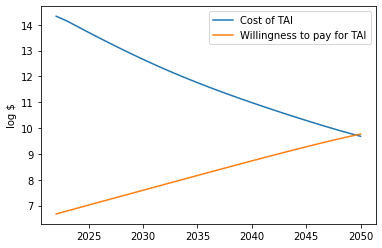

## RUN 2/10000 ##
It takes 28.9 log FLOPs (~10 octillion) for transformative capabilities.
Every 3.3 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.2 log 2022$USD (~one million) and this increases by 0.7x per year to a max of 0.0014% of GDP. GDP grows at a rate of 1.013x per year.
In this simulation, if we are 90.0% of the way to paying for TAI, we will ramp to paying for TAI.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 4.8 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.2 max log FLOP (one septillion) available - TAI takes 28.9 log FLOP (10 octillion) - log $ 10.9 to buy TAI (10 billion) vs. willingness to pay log $ 6.2 (one million) - 18.0 log FLOPS per $ (100 quadrillion)
Ye

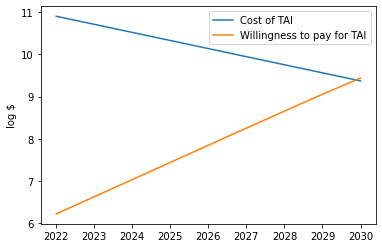

## RUN 3/10000 ##
It takes 34.6 log FLOPs (~10 decillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 3.7 log reductions possible.
FLOPs start at a cost of 17.9 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 25.7 log FLOPs (~10 septillion) per 2022$USD.
We are willing to pay 6.2 log 2022$USD (~one million) and this increases by 0.7x per year to a max of 0.0001% of GDP. GDP grows at a rate of 1.017x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 2.6 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.0 max log FLOP (one septillion) available - TAI takes 34.6 log FLOP (10 decillion) - log $ 16.8 to buy TAI (10 quadrillion) vs. willingness to pay log $ 6.2 (one million) - 17.9 log FLOPS per $ (100 quadrillion)
Year: 2023 - 24.6 max log FLOP (one se

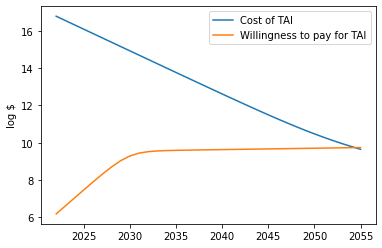

## RUN 4/10000 ##
It takes 29.4 log FLOPs (~100 octillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 17.9 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 27.3 log FLOPs (~one octillion) per 2022$USD.
We are willing to pay 6.9 log 2022$USD (~one million) and this increases by 1.5x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.029x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 20.0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.7 max log FLOP (one septillion) available - TAI takes 29.4 log FLOP (100 octillion) - log $ 11.5 to buy TAI (100 billion) vs. willingness to pay log $ 6.9 (one million) - 17.9 log FLOPS per $ (100 quadrillion)
Year: 2023 - 25.0 max log FLOP (10 sep

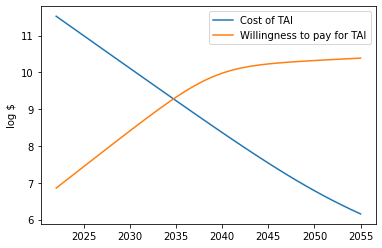

## RUN 5/10000 ##
It takes 24.1 log FLOPs (~one septillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 18.2 log FLOPs (~one quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (~10 septillion) per 2022$USD.
We are willing to pay 6.3 log 2022$USD (~one million) and this increases by 2.7x per year to a max of 0.0004% of GDP. GDP grows at a rate of 1.024x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 2.3 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.5 max log FLOP (one septillion) available - TAI takes 24.1 log FLOP (one septillion) - log $ 5.9 to buy TAI (100 thousand) vs. willingness to pay log $ 6.3 (one million) - 18.2 log FLOPS per $ (one quintillion)
-- Nonscaling delay occured p_nonscal

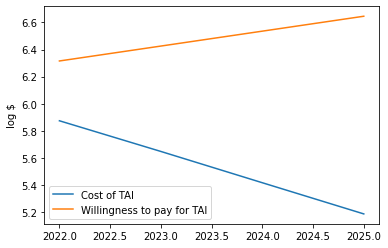

## RUN 6/10000 ##
It takes 42.2 log FLOPs (~one billion decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 4.5 log reductions possible.
FLOPs start at a cost of 17.6 log FLOPs (~100 quadrillion) per 2022$USD. Every 4.1 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (~10 septillion) per 2022$USD.
We are willing to pay 5.8 log 2022$USD (~100 thousand) and this increases by 0.7x per year to a max of 0.0001% of GDP. GDP grows at a rate of 1.02x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 6.5 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 23.4 max log FLOP (100 sextillion) available - TAI takes 42.2 log FLOP (one billion decillion) - log $ 24.6 to buy TAI (one septillion) vs. willingness to pay log $ 5.8 (100 thousand) - 17.6 log FLOPS per $ (100 quadrillion)
Year: 2023 - 23.9 m

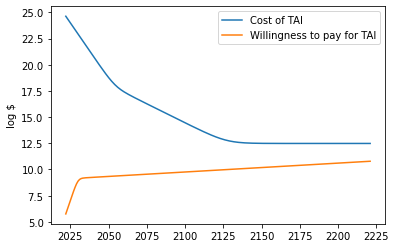

## RUN 7/10000 ##
It takes 33.3 log FLOPs (~one decillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 17.8 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.3 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.3 log 2022$USD (~one million) and this increases by 1.9x per year to a max of 0.0002% of GDP. GDP grows at a rate of 1.036x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 23.7 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.1 max log FLOP (one septillion) available - TAI takes 33.3 log FLOP (one decillion) - log $ 15.4 to buy TAI (one quadrillion) vs. willingness to pay log $ 6.3 (one million) - 17.8 log FLOPS per $ (100 quadrillion)
Year: 2023 - 24.4 max log FLOP (o

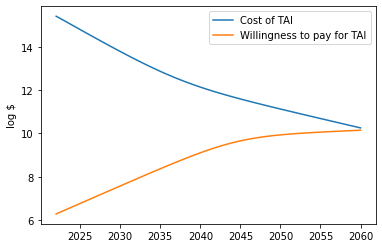

## RUN 8/10000 ##
It takes 25.4 log FLOPs (~10 septillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 18.6 log FLOPs (~one quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 26.8 log FLOPs (~100 septillion) per 2022$USD.
We are willing to pay 7.0 log 2022$USD (~one million) and this increases by 0.5x per year to a max of 0.0003% of GDP. GDP grows at a rate of 1.021x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 3.6 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.6 max log FLOP (10 septillion) available - TAI takes 25.4 log FLOP (10 septillion) - log $ 6.7 to buy TAI (one million) vs. willingness to pay log $ 7.0 (one million) - 18.6 log FLOPS per $ (one quintillion)
-- Nonscaling delay occured p_nonscaling

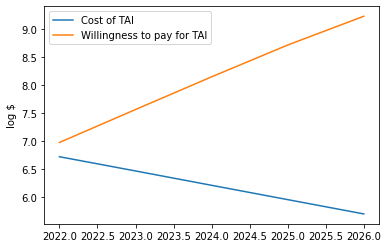

## RUN 9/10000 ##
It takes 30.3 log FLOPs (~one nonillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.3 log FLOPs (~one quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.6 log 2022$USD (~one million) and this increases by 0.8x per year to a max of 0.0007% of GDP. GDP grows at a rate of 1.032x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 7.4 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.9 max log FLOP (one septillion) available - TAI takes 30.3 log FLOP (one nonillion) - log $ 12.1 to buy TAI (one trillion) vs. willingness to pay log $ 6.6 (one million) - 18.3 log FLOPS per $ (one quintillion)
Year: 2023 - 25.4 max log FLOP (10 se

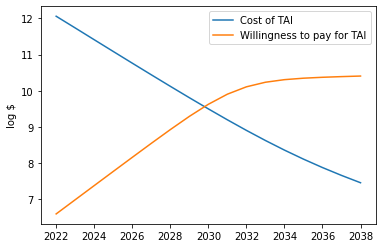

## RUN 10/10000 ##
It takes 34.3 log FLOPs (~10 decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 18.3 log FLOPs (~one quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (~10 septillion) per 2022$USD.
We are willing to pay 6.6 log 2022$USD (~one million) and this increases by 1.7x per year to a max of 0.001% of GDP. GDP grows at a rate of 1.02x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 6.1 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.9 max log FLOP (one septillion) available - TAI takes 34.3 log FLOP (10 decillion) - log $ 16.0 to buy TAI (10 quadrillion) vs. willingness to pay log $ 6.6 (one million) - 18.3 log FLOPS per $ (one quintillion)
Year: 2023 - 25.2 max log FLOP (10 sept

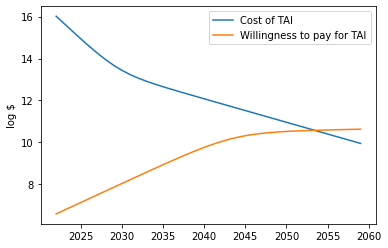

## RUN 11/10000 ##
It takes 35.9 log FLOPs (~100 decillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 17.6 log FLOPs (~100 quadrillion) per 2022$USD. Every 4.2 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.6 log 2022$USD (~one million) and this increases by 0.9x per year to a max of 0.0012% of GDP. GDP grows at a rate of 1.028x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 10.2 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.1 max log FLOP (one septillion) available - TAI takes 35.9 log FLOP (100 decillion) - log $ 18.3 to buy TAI (one quintillion) vs. willingness to pay log $ 6.6 (one million) - 17.6 log FLOPS per $ (100 quadrillion)
Year: 2023 - 24.5 max log FLOP (

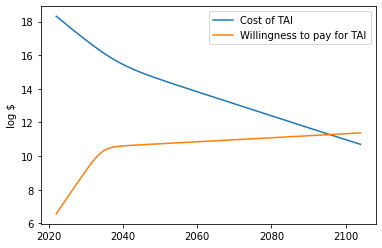

## RUN 12/10000 ##
It takes 39.8 log FLOPs (~one million decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 3.7 log reductions possible.
FLOPs start at a cost of 17.9 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 25.9 log FLOPs (~10 septillion) per 2022$USD.
We are willing to pay 6.5 log 2022$USD (~one million) and this increases by 1.7x per year to a max of 0.0002% of GDP. GDP grows at a rate of 1.025x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 5.3 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.4 max log FLOP (one septillion) available - TAI takes 39.8 log FLOP (one million decillion) - log $ 21.9 to buy TAI (one sextillion) vs. willingness to pay log $ 6.5 (one million) - 17.9 log FLOPS per $ (100 quadrillion)
Year: 2023 - 24.7 m

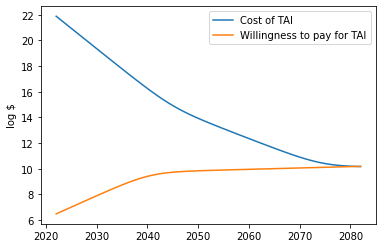

## RUN 13/10000 ##
It takes 21.6 log FLOPs (~one sextillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 17.7 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 25.0 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.6 log 2022$USD (~one million) and this increases by 1.0x per year to a max of 0.0001% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 3.7 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.3 max log FLOP (one septillion) available - TAI takes 21.6 log FLOP (one sextillion) - log $ 4.0 to buy TAI (one thousand) vs. willingness to pay log $ 6.6 (one million) - 17.7 log FLOPS per $ (100 quadrillion)
-- Nonscaling delay occured p_nonsca

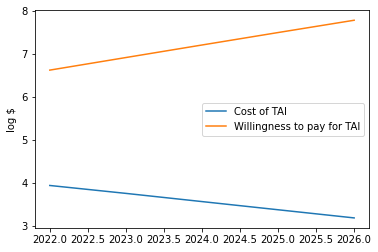

## RUN 14/10000 ##
It takes 39.0 log FLOPs (~100 thousand decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.4 log FLOPs (~one sextillion) per 2022$USD.
We are willing to pay 6.2 log 2022$USD (~one million) and this increases by 3.5x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.021x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 4.9 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.2 max log FLOP (one septillion) available - TAI takes 39.0 log FLOP (100 thousand decillion) - log $ 21.0 to buy TAI (100 quintillion) vs. willingness to pay log $ 6.2 (one million) - 18.0 log FLOPS per $ (one quintillion)
Year: 2023 - 24

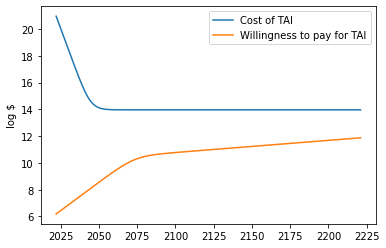

## RUN 15/10000 ##
It takes 36.0 log FLOPs (~one thousand decillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~100 sextillion) per 2022$USD.
We are willing to pay 6.7 log 2022$USD (~one million) and this increases by 1.3x per year to a max of 0.0004% of GDP. GDP grows at a rate of 1.026x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 19.7 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.2 max log FLOP (one septillion) available - TAI takes 36.0 log FLOP (one thousand decillion) - log $ 18.5 to buy TAI (one quintillion) vs. willingness to pay log $ 6.7 (one million) - 17.5 log FLOPS per $ (100 quadrillion)
Year: 2023 - 2

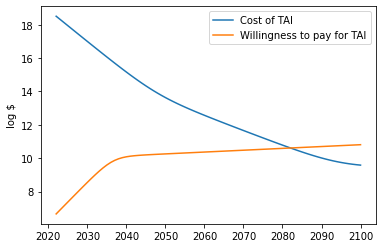

## RUN 16/10000 ##
It takes 33.4 log FLOPs (~one decillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 17.6 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.2 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.8 log 2022$USD (~one million) and this increases by 0.9x per year to a max of 0.0007% of GDP. GDP grows at a rate of 1.024x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 4.3 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.3 max log FLOP (one septillion) available - TAI takes 33.4 log FLOP (one decillion) - log $ 15.8 to buy TAI (one quadrillion) vs. willingness to pay log $ 6.8 (one million) - 17.6 log FLOPS per $ (100 quadrillion)
Year: 2023 - 24.7 max log FLOP (o

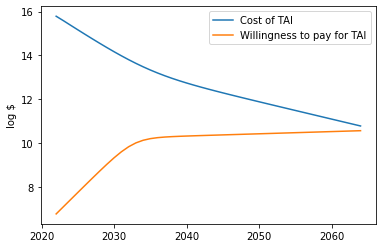

## RUN 17/10000 ##
It takes 27.1 log FLOPs (~one octillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 1.3 log reductions possible.
FLOPs start at a cost of 17.8 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 27.7 log FLOPs (~one octillion) per 2022$USD.
We are willing to pay 6.2 log 2022$USD (~one million) and this increases by 1.4x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.02x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 14.4 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.1 max log FLOP (one septillion) available - TAI takes 27.1 log FLOP (one octillion) - log $ 9.3 to buy TAI (one billion) vs. willingness to pay log $ 6.2 (one million) - 17.8 log FLOPS per $ (100 quadrillion)
Year: 2023 - 24.3 max log FLOP (one septi

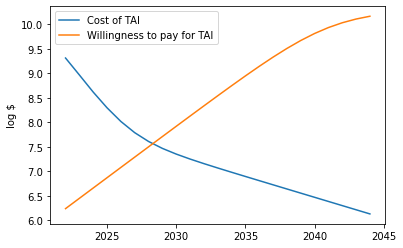

## RUN 18/10000 ##
It takes 30.5 log FLOPs (~one nonillion) for transformative capabilities.
Every 3.6 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.6 log FLOPs (~100 sextillion) per 2022$USD.
We are willing to pay 6.6 log 2022$USD (~one million) and this increases by 1.3x per year to a max of 0.0003% of GDP. GDP grows at a rate of 1.032x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 11.9 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.6 max log FLOP (one septillion) available - TAI takes 30.5 log FLOP (one nonillion) - log $ 12.5 to buy TAI (one trillion) vs. willingness to pay log $ 6.6 (one million) - 18.0 log FLOPS per $ (one quintillion)
Year: 2023 - 24.9 max log FLOP (one

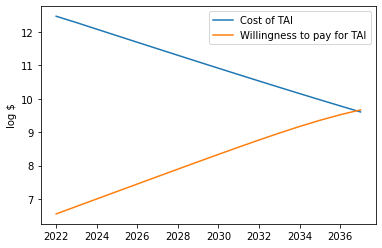

## RUN 19/10000 ##
It takes 34.4 log FLOPs (~10 decillion) for transformative capabilities.
Every 3.1 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 18.1 log FLOPs (~one quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 24.2 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.1 log 2022$USD (~one million) and this increases by 1.4x per year to a max of 0.0012% of GDP. GDP grows at a rate of 1.023x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 50.3 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.2 max log FLOP (one septillion) available - TAI takes 34.4 log FLOP (10 decillion) - log $ 16.3 to buy TAI (10 quadrillion) vs. willingness to pay log $ 6.1 (one million) - 18.1 log FLOPS per $ (one quintillion)
Year: 2023 - 24.5 max log FLOP (one

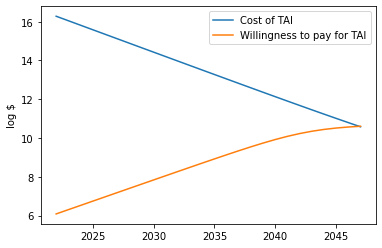

## RUN 20/10000 ##
It takes 25.8 log FLOPs (~10 septillion) for transformative capabilities.
Every 4.5 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (~10 septillion) per 2022$USD.
We are willing to pay 6.3 log 2022$USD (~one million) and this increases by 2.2x per year to a max of 0.0002% of GDP. GDP grows at a rate of 1.02x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 36.3 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.3 max log FLOP (one septillion) available - TAI takes 25.8 log FLOP (10 septillion) - log $ 7.8 to buy TAI (10 million) vs. willingness to pay log $ 6.3 (one million) - 18.0 log FLOPS per $ (one quintillion)
Year: 2023 - 24.6 max log FLOP (one sept

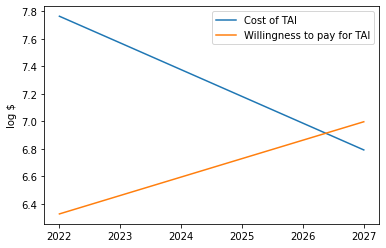

## RUN 21/10000 ##
It takes 35.2 log FLOPs (~100 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 17.8 log FLOPs (~100 quadrillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.3 log 2022$USD (~one million) and this increases by 0.8x per year to a max of 0.0001% of GDP. GDP grows at a rate of 1.03x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 3.0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.1 max log FLOP (one septillion) available - TAI takes 35.2 log FLOP (100 decillion) - log $ 17.4 to buy TAI (100 quadrillion) vs. willingness to pay log $ 6.3 (one million) - 17.8 log FLOPS per $ (100 quadrillion)
Year: 2023 - 24.6 max log FLOP (on

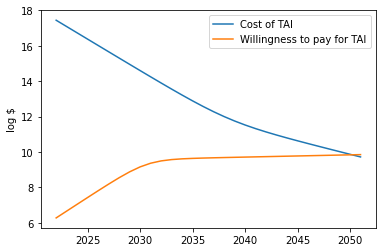

## RUN 22/10000 ##
It takes 21.6 log FLOPs (~one sextillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.1 log FLOPs (~one quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 28.2 log FLOPs (~10 octillion) per 2022$USD.
We are willing to pay 6.5 log 2022$USD (~one million) and this increases by 2.7x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.037x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 4.3 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.6 max log FLOP (one septillion) available - TAI takes 21.6 log FLOP (one sextillion) - log $ 3.5 to buy TAI (one thousand) vs. willingness to pay log $ 6.5 (one million) - 18.1 log FLOPS per $ (one quintillion)
-- Nonscaling issue did not occur p_n

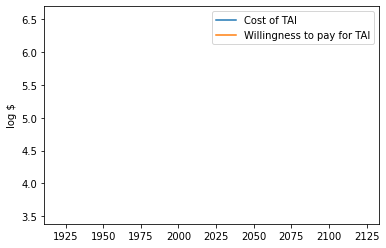

## RUN 23/10000 ##
It takes 44.2 log FLOPs (~100 billion decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 4.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~one quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.6 log FLOPs (~10 sextillion) per 2022$USD.
We are willing to pay 6.3 log 2022$USD (~one million) and this increases by 1.4x per year to a max of 0.0003% of GDP. GDP grows at a rate of 1.033x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 6.8 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.3 max log FLOP (one septillion) available - TAI takes 44.2 log FLOP (100 billion decillion) - log $ 26.2 to buy TAI (100 septillion) vs. willingness to pay log $ 6.3 (one million) - 18.0 log FLOPS per $ (one quintillion)
Year: 2023 - 24.6 m

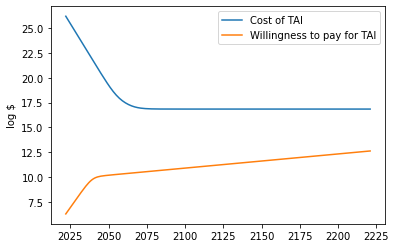

## RUN 24/10000 ##
It takes 32.1 log FLOPs (~100 nonillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 18.5 log FLOPs (~one quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 20.8 log FLOPs (~100 quintillion) per 2022$USD.
We are willing to pay 6.6 log 2022$USD (~one million) and this increases by 0.7x per year to a max of 0.0001% of GDP. GDP grows at a rate of 1.031x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 19.2 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.1 max log FLOP (10 septillion) available - TAI takes 32.1 log FLOP (100 nonillion) - log $ 13.6 to buy TAI (10 trillion) vs. willingness to pay log $ 6.6 (one million) - 18.5 log FLOPS per $ (one quintillion)
Year: 2023 - 25.6 max log FLOP (10 s

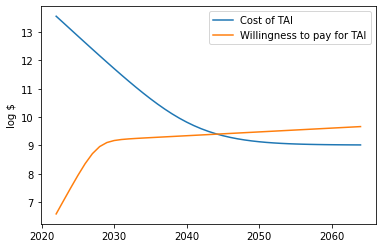

## RUN 25/10000 ##
It takes 32.9 log FLOPs (~100 nonillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 17.7 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.6 log FLOPs (~one septillion) per 2022$USD.
We are willing to pay 6.2 log 2022$USD (~one million) and this increases by 1.9x per year to a max of 0.0012% of GDP. GDP grows at a rate of 1.029x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 7.0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 23.9 max log FLOP (100 sextillion) available - TAI takes 32.9 log FLOP (100 nonillion) - log $ 15.2 to buy TAI (one quadrillion) vs. willingness to pay log $ 6.2 (one million) - 17.7 log FLOPS per $ (100 quadrillion)
Year: 2023 - 24.1 max log FLOP (o

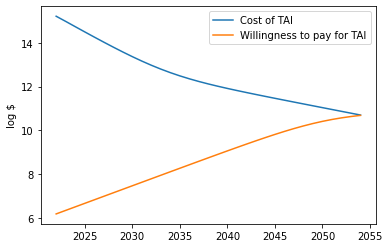

## RUN 26/10000 ##
It takes 29.2 log FLOPs (~100 octillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 1.4 log reductions possible.
FLOPs start at a cost of 17.8 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 26.1 log FLOPs (~100 septillion) per 2022$USD.
We are willing to pay 6.7 log 2022$USD (~one million) and this increases by 0.6x per year to a max of 0.0002% of GDP. GDP grows at a rate of 1.016x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 16.3 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.5 max log FLOP (one septillion) available - TAI takes 29.2 log FLOP (100 octillion) - log $ 11.4 to buy TAI (100 billion) vs. willingness to pay log $ 6.7 (one million) - 17.8 log FLOPS per $ (100 quadrillion)
Year: 2023 - 25.1 max log FLOP (10 s

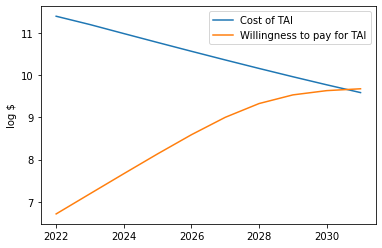

## RUN 27/10000 ##
It takes 30.3 log FLOPs (~one nonillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.4 log FLOPs (~one quintillion) per 2022$USD. Every 4.4 years they get 2x cheaper, to a maximum of 22.2 log FLOPs (~10 sextillion) per 2022$USD.
We are willing to pay 6.8 log 2022$USD (~one million) and this increases by 0.7x per year to a max of 0.0001% of GDP. GDP grows at a rate of 1.015x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 7.0 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.2 max log FLOP (10 septillion) available - TAI takes 30.3 log FLOP (one nonillion) - log $ 11.9 to buy TAI (100 billion) vs. willingness to pay log $ 6.8 (one million) - 18.4 log FLOPS per $ (one quintillion)
Year: 2023 - 25.7 max log FLOP (10 sept

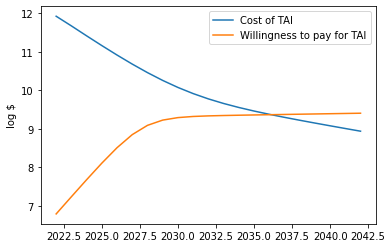

## RUN 28/10000 ##
It takes 24.5 log FLOPs (~one septillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 17.9 log FLOPs (~100 quadrillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~100 sextillion) per 2022$USD.
We are willing to pay 6.0 log 2022$USD (~one million) and this increases by 0.9x per year to a max of 0.0007% of GDP. GDP grows at a rate of 1.025x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 1.9 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.0 max log FLOP (100 sextillion) available - TAI takes 24.5 log FLOP (one septillion) - log $ 6.5 to buy TAI (one million) vs. willingness to pay log $ 6.0 (one million) - 17.9 log FLOPS per $ (100 quadrillion)
-$- We have enough spend to make TAI

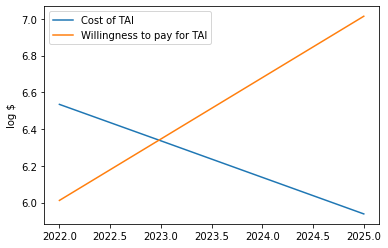

## RUN 29/10000 ##
It takes 32.5 log FLOPs (~100 nonillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.4 log FLOPs (~one quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 26.5 log FLOPs (~100 septillion) per 2022$USD.
We are willing to pay 6.3 log 2022$USD (~one million) and this increases by 1.1x per year to a max of 0.0002% of GDP. GDP grows at a rate of 1.021x per year.
In this simulation, if we are 68.0% of the way to paying for TAI, we will ramp to paying for TAI.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 9.9 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 24.7 max log FLOP (one septillion) available - TAI takes 32.5 log FLOP (100 nonillion) - log $ 14.1 to buy TAI (100 trillion) vs. willingness to pay log $ 6.3 (one million) - 18.4 log FLOPS per $ (one quintillio

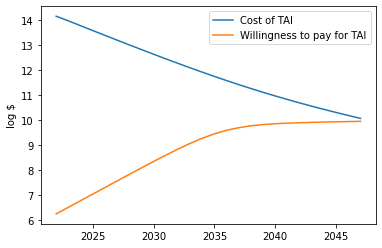

## RUN 30/10000 ##
It takes 40.6 log FLOPs (~10 million decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 4.5 log reductions possible.
FLOPs start at a cost of 18.3 log FLOPs (~one quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.7 log FLOPs (~10 sextillion) per 2022$USD.
We are willing to pay 6.7 log 2022$USD (~one million) and this increases by 0.6x per year to a max of 0.0004% of GDP. GDP grows at a rate of 1.023x per year.
In this simulation, there are no willingness ramp effects.
We are willing to spend over 10 years to make TAI
If a non-scaling delay happens, it will take an additional 7.9 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2022 - 25.0 max log FLOP (10 septillion) available - TAI takes 40.6 log FLOP (10 million decillion) - log $ 22.3 to buy TAI (10 sextillion) vs. willingness to pay log $ 6.7 (one million) - 18.3 log FLOPS per $ (one quintillion)
Year: 2023 - 25.7 max l

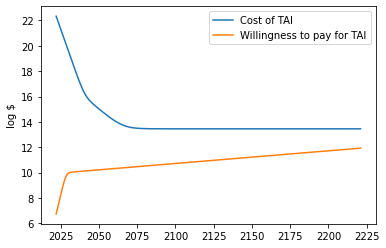

## RUN 201/10000 ##
## RUN 401/10000 ##
## RUN 601/10000 ##
## RUN 801/10000 ##
## RUN 1001/10000 ##
## RUN 1201/10000 ##
## RUN 1401/10000 ##
## RUN 1601/10000 ##
## RUN 1801/10000 ##
## RUN 2001/10000 ##
## RUN 2201/10000 ##
## RUN 2401/10000 ##
## RUN 2601/10000 ##
## RUN 2801/10000 ##
## RUN 3001/10000 ##
## RUN 3201/10000 ##
## RUN 3401/10000 ##
## RUN 3601/10000 ##
## RUN 3801/10000 ##
## RUN 4001/10000 ##
## RUN 4201/10000 ##
## RUN 4401/10000 ##
## RUN 4601/10000 ##
## RUN 4801/10000 ##
## RUN 5001/10000 ##
## RUN 5201/10000 ##
## RUN 5401/10000 ##
## RUN 5601/10000 ##
## RUN 5801/10000 ##
## RUN 6001/10000 ##
## RUN 6201/10000 ##
## RUN 6401/10000 ##
## RUN 6601/10000 ##
## RUN 6801/10000 ##
## RUN 7001/10000 ##
## RUN 7201/10000 ##
## RUN 7401/10000 ##
## RUN 7601/10000 ##
## RUN 7801/10000 ##
## RUN 8001/10000 ##
## RUN 8201/10000 ##
## RUN 8401/10000 ##
## RUN 8601/10000 ##
## RUN 8801/10000 ##
## RUN 9001/10000 ##
## RUN 9201/10000 ##
## RUN 9401/10000 ##
## RUN 9601/10000

In [169]:
# TODO: Refactor this out into a function that is called in a loop, so then a single run can be done
# with custom variables to do sensitivity analyses

tai_years = []
print('Running')

for r in range(RUNS):
    print_diagnostic = r < 30
    if print_diagnostic or r % 200 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    
    tai_flop_size_ = sample(tai_flop_size)
    if tai_flop_size_ > 300:
        tai_flop_size_ = int(tai_flop_size_) # Handle overflow errors
    
    algo_doubling_rate_ = algo_halving_fn(sample(algo_doubling_rate_min),
                                          sample(algo_doubling_rate_max),
                                          tai_flop_size_)
    
    possible_algo_reduction_ = possible_algo_reduction_fn(sample(min_reduction),
                                                          sample(max_reduction),
                                                          tai_flop_size_)
    initial_flops_per_dollar_ = 10 ** sample(initial_flops_per_dollar)
    flops_halving_rate_ = sample(flops_halving_rate)
    max_flops_per_dollar_ = 10 ** sample(max_flops_per_dollar)
    initial_pay_ = 10 ** sample(initial_pay)
    gdp_growth_ = sample(gdp_growth)
    max_gdp_frac_ = sample(max_gdp_frac)
    
    willingness_ramp_happens = event_occurs(p_willingness_ramp)
    if willingness_ramp_happens:
        willingness_ramp_ = sample(willingness_ramp)
    else:
        willingness_ramp_ = 1
        
    spend_doubling_time_ = sample(spend_doubling_time)
    nonscaling_delay_ = sample(nonscaling_delay)
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    nonscaling_issue_bottom_year_ = nonscaling_issue_bottom_year
    willingness_spend_horizon_ = willingness_spend_horizon
    
    y = run_model(tai_flop_size_=tai_flop_size_,
                  nonscaling_delay_=nonscaling_delay_,
                  algo_doubling_rate_=algo_doubling_rate_,
                  possible_algo_reduction_=possible_algo_reduction_,
                  initial_flops_per_dollar_=initial_flops_per_dollar_,
                  flops_halving_rate_=flops_halving_rate_,
                  max_flops_per_dollar_=max_flops_per_dollar_,
                  initial_pay_=initial_pay_,
                  gdp_growth_=gdp_growth_,
                  max_gdp_frac_=max_gdp_frac_,
                  willingness_ramp_=willingness_ramp_,
                  spend_doubling_time_=spend_doubling_time_,
                  initial_chance_of_nonscaling_issue_=initial_chance_of_nonscaling_issue_,
                  final_chance_of_nonscaling_issue_=final_chance_of_nonscaling_issue_,
                  nonscaling_issue_bottom_year_=nonscaling_issue_bottom_year_,
                  willingness_spend_horizon_=willingness_spend_horizon_,
                  print_diagnostic=print_diagnostic)
    tai_years.append(y)


In [170]:
out = get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Aug 9 9:19AM CT):
# '1%: 2024',
# '5%: 2028',
# '10%: 2031',
# '20%: 2037',
# '30%: 2043',
# '40%: 2049',
# '50%: 2056',
# '60%: 2064',
# '70%: 2077',
# '80%: 2100',
# '90%: >2222',
# '95%: >2222',
# '99%: >2222']


['1%: 2024',
 '5%: 2028',
 '10%: 2031',
 '20%: 2036',
 '30%: 2040',
 '40%: 2046',
 '50%: 2051',
 '60%: 2058',
 '70%: 2069',
 '80%: 2087',
 '90%: 2192',
 '95%: >2222',
 '99%: >2222']

In [171]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['1%: 2 years from now',
 '5%: 6 years from now',
 '10%: 9 years from now',
 '20%: 14 years from now',
 '30%: 18 years from now',
 '40%: 24 years from now',
 '50%: 29 years from now',
 '60%: 36 years from now',
 '70%: 47 years from now',
 '80%: 65 years from now',
 '90%: 170 years from now',
 '95%: >200 years from now',
 '99%: >200 years from now']

In [172]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <1 years')
print_chance_tai_by_year(tai_years, 2022)


## Within <1 years


'1% chance of TAI by EOY 2022'

In [173]:
print('## Within <1 years')
print_chance_tai_by_year(tai_years, 2023)

## Within <1 years


'1% chance of TAI by EOY 2023'

In [174]:
print_chance_tai_by_year(tai_years, 2024)

'1% chance of TAI by EOY 2024'

In [175]:
print_chance_tai_by_year(tai_years, 2025)

'2% chance of TAI by EOY 2025'

In [176]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'4% chance of TAI by EOY 2027'

In [177]:
print_chance_tai_by_year(tai_years, 2029)

'7% chance of TAI by EOY 2029'

In [178]:
print_chance_tai_by_year(tai_years, 2030)

'9% chance of TAI by EOY 2030'

In [179]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'13% chance of TAI by EOY 2032'

In [180]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'22% chance of TAI by EOY 2036'

In [181]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'24% chance of TAI by EOY 2037'

In [182]:
print_chance_tai_by_year(tai_years, 2040)

'30% chance of TAI by EOY 2040'

In [183]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'34% chance of TAI by EOY 2042'

In [184]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'44% chance of TAI by EOY 2047'

In [185]:
print_chance_tai_by_year(tai_years, 2050)

'49% chance of TAI by EOY 2050'

In [186]:
print_chance_tai_by_year(tai_years, 2060)

'63% chance of TAI by EOY 2060'

In [187]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'63% chance of TAI by EOY 2060'

In [188]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'71% chance of TAI by EOY 2070'

In [189]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'72% chance of TAI by EOY 2072'

In [190]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'76% chance of TAI by EOY 2078'

In [191]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'83% chance of TAI by EOY 2097'

In [192]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'84% chance of TAI by EOY 2100'

In [193]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'87% chance of TAI by EOY 2122'

In [194]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'91% chance of TAI by EOY 2222'

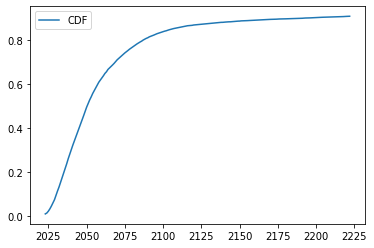

In [195]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

<string>:265: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:266: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

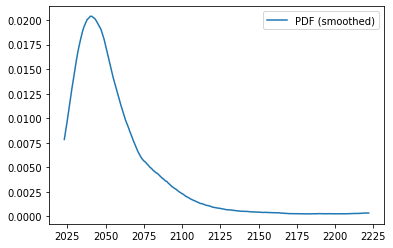

In [196]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [197]:
cdf[:len(bins)]

array([0.0082, 0.0123, 0.0206, 0.0313, 0.0441, 0.0583, 0.0728, 0.0931,
       0.1127, 0.1312, 0.152 , 0.1729, 0.1939, 0.2156, 0.2366, 0.2597,
       0.2808, 0.3012, 0.3215, 0.3404, 0.3593, 0.3784, 0.3968, 0.4159,
       0.4355, 0.4544, 0.4744, 0.4939, 0.5101, 0.5271, 0.5412, 0.5568,
       0.5695, 0.583 , 0.595 , 0.6082, 0.6178, 0.6275, 0.6374, 0.6481,
       0.6557, 0.6664, 0.673 , 0.6801, 0.6867, 0.6939, 0.7023, 0.7101,
       0.7164, 0.7226, 0.7289, 0.7356, 0.7414, 0.7467, 0.7523, 0.7581,
       0.7631, 0.7679, 0.7737, 0.7787, 0.7827, 0.7872, 0.7913, 0.7951,
       0.8001, 0.8041, 0.8077, 0.8105, 0.8147, 0.8174, 0.8206, 0.8228,
       0.8261, 0.8289, 0.8313, 0.8342, 0.8364, 0.839 , 0.8405, 0.8422,
       0.8447, 0.8469, 0.8489, 0.8508, 0.8525, 0.8539, 0.8553, 0.8564,
       0.8579, 0.8595, 0.8613, 0.8625, 0.8639, 0.8652, 0.8658, 0.8666,
       0.8671, 0.8686, 0.8694, 0.8704, 0.8713, 0.872 , 0.8728, 0.8732,
       0.8745, 0.8751, 0.8756, 0.8762, 0.8769, 0.8779, 0.8785, 0.8787,
      

In [198]:
pdf[:len(bins)]

array([0.0082, 0.0041, 0.0083, 0.0107, 0.0128, 0.0142, 0.0145, 0.0203,
       0.0196, 0.0185, 0.0208, 0.0209, 0.021 , 0.0217, 0.021 , 0.0231,
       0.0211, 0.0204, 0.0203, 0.0189, 0.0189, 0.0191, 0.0184, 0.0191,
       0.0196, 0.0189, 0.02  , 0.0195, 0.0162, 0.017 , 0.0141, 0.0156,
       0.0127, 0.0135, 0.012 , 0.0132, 0.0096, 0.0097, 0.0099, 0.0107,
       0.0076, 0.0107, 0.0066, 0.0071, 0.0066, 0.0072, 0.0084, 0.0078,
       0.0063, 0.0062, 0.0063, 0.0067, 0.0058, 0.0053, 0.0056, 0.0058,
       0.005 , 0.0048, 0.0058, 0.005 , 0.004 , 0.0045, 0.0041, 0.0038,
       0.005 , 0.004 , 0.0036, 0.0028, 0.0042, 0.0027, 0.0032, 0.0022,
       0.0033, 0.0028, 0.0024, 0.0029, 0.0022, 0.0026, 0.0015, 0.0017,
       0.0025, 0.0022, 0.002 , 0.0019, 0.0017, 0.0014, 0.0014, 0.0011,
       0.0015, 0.0016, 0.0018, 0.0012, 0.0014, 0.0013, 0.0006, 0.0008,
       0.0005, 0.0015, 0.0008, 0.001 , 0.0009, 0.0007, 0.0008, 0.0004,
       0.0013, 0.0006, 0.0005, 0.0006, 0.0007, 0.001 , 0.0006, 0.0002,
      

<string>:265: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:266: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

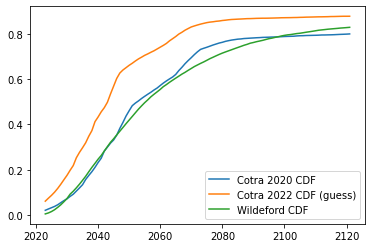

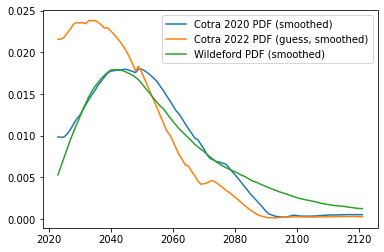

In [199]:
cotra_2020_cdf = [0.0214, 0.0272, 0.0328, 0.0385, 0.0458, 0.0551, 0.0641, 0.0721,
       0.0827, 0.0923, 0.1061, 0.1199, 0.1343, 0.1574, 0.175 , 0.1917,
       0.2108, 0.2321, 0.251 , 0.2825, 0.3001, 0.3177, 0.3317, 0.3531,
       0.3829, 0.4089, 0.4372, 0.4606, 0.4829, 0.4944, 0.504 , 0.5147,
       0.5243, 0.5335, 0.5423, 0.5521, 0.5608, 0.5719, 0.5826, 0.5922,
       0.6011, 0.6096, 0.6209, 0.6379, 0.6524, 0.6682, 0.682 , 0.6948,
       0.7084, 0.7207, 0.7314, 0.7362, 0.7407, 0.7456, 0.7506, 0.755 ,
       0.7594, 0.7626, 0.7668, 0.7698, 0.7725, 0.7745, 0.7765, 0.7775,
       0.7793, 0.7801, 0.781 , 0.7818, 0.7827, 0.7833, 0.7843, 0.7847,
       0.7852, 0.7858, 0.7861, 0.7868, 0.7874, 0.7882, 0.7887, 0.7891,
       0.7895, 0.7908, 0.7916, 0.7918, 0.7926, 0.7929, 0.7933, 0.7936,
       0.7941, 0.7949, 0.795 , 0.7954, 0.7957, 0.7962, 0.7969, 0.7976,
       0.7981, 0.7987, 0.7996, 0.8002, 0.8004, 0.801 , 0.8015, 0.8021,
       0.8025, 0.8029, 0.8034, 0.8041, 0.8045, 0.8052, 0.8059, 0.806 ,
       0.8066, 0.8071, 0.8079, 0.8087, 0.8089, 0.8093, 0.8093, 0.8095,
       0.8105, 0.8109, 0.8114, 0.8118, 0.8128, 0.8132, 0.8139, 0.8139,
       0.8144, 0.8149, 0.8154, 0.8162, 0.8167, 0.8173, 0.8177, 0.8185,
       0.8196, 0.82  , 0.821 , 0.8217, 0.8224, 0.8233, 0.8244, 0.8247,
       0.8254, 0.8262, 0.8267, 0.8274, 0.8277, 0.8288, 0.8294, 0.8298,
       0.8305, 0.8318, 0.8328, 0.8335, 0.8343, 0.8347, 0.8351, 0.8361,
       0.837 , 0.8376, 0.8385, 0.8398, 0.8404, 0.8413, 0.8419, 0.8427,
       0.8437, 0.8448, 0.8458, 0.8462, 0.8471, 0.8482, 0.8487, 0.8491,
       0.8498, 0.8505, 0.8507, 0.8511, 0.8519, 0.8526, 0.8534, 0.8542,
       0.855 , 0.8554, 0.8559, 0.8565, 0.857 , 0.8575, 0.8581, 0.8587,
       0.8592, 0.86  , 0.8605, 0.861 , 0.8615, 0.862 , 0.8629]
cotra_2020_pdf = np.append(np.array(cotra_2020_cdf[0]), np.diff(cotra_2020_cdf[:len(bins)]))
cotra_2020_pdf_smoothed = savitzky_golay(cotra_2020_pdf[:len(bins)], 51, 3)

cotra_2022_cdf = [0.0616, 0.0747, 0.0873, 0.1015, 0.118 , 0.1365, 0.1564, 0.1758,
       0.1981, 0.2188, 0.2531, 0.2768, 0.2975, 0.3193, 0.3481, 0.3728,
       0.4124, 0.433 , 0.4557, 0.4742, 0.4981, 0.5348, 0.569 , 0.6032,
       0.627 , 0.6404, 0.6507, 0.6611, 0.6701, 0.6801, 0.6893, 0.697 ,
       0.7051, 0.7115, 0.7186, 0.7252, 0.7331, 0.7411, 0.749 , 0.7577,
       0.7691, 0.7785, 0.7881, 0.799 , 0.807 , 0.8161, 0.8233, 0.8303,
       0.8348, 0.839 , 0.8429, 0.8462, 0.8494, 0.8517, 0.8532, 0.8553,
       0.8566, 0.8588, 0.8602, 0.862 , 0.8633, 0.864 , 0.8648, 0.8654,
       0.8662, 0.867 , 0.8672, 0.8677, 0.8683, 0.8686, 0.8689, 0.8689,
       0.8692, 0.8695, 0.8699, 0.8703, 0.8709, 0.8711, 0.8713, 0.8715,
       0.8719, 0.8721, 0.8727, 0.873 , 0.8736, 0.8739, 0.8742, 0.8746,
       0.875 , 0.8751, 0.8754, 0.8757, 0.8763, 0.8764, 0.8768, 0.8772,
       0.8775, 0.8775, 0.8776, 0.8779, 0.878 , 0.8781, 0.8783, 0.8789,
       0.8792, 0.8794, 0.8795, 0.8798, 0.8805, 0.8808, 0.8814, 0.8819,
       0.8822, 0.8826, 0.8827, 0.8828, 0.8832, 0.8834, 0.8837, 0.8839,
       0.8842, 0.8848, 0.8857, 0.8859, 0.8861, 0.8863, 0.8866, 0.8869,
       0.8869, 0.8873, 0.8878, 0.8889, 0.8896, 0.8904, 0.8906, 0.8911,
       0.8915, 0.892 , 0.8929, 0.8934, 0.8937, 0.8942, 0.8946, 0.8954,
       0.8959, 0.8963, 0.8969, 0.8972, 0.8975, 0.8984, 0.8988, 0.8993,
       0.8999, 0.9004, 0.9007, 0.9015, 0.9019, 0.9021, 0.9026, 0.9031,
       0.9037, 0.9041, 0.9048, 0.9054, 0.9057, 0.9062, 0.9067, 0.9075,
       0.9084, 0.9088, 0.909 , 0.9101, 0.9106, 0.9108, 0.9114, 0.9116,
       0.9121, 0.9127, 0.913 , 0.9137, 0.9144, 0.9147, 0.9154, 0.9159,
       0.9161, 0.9166, 0.9173, 0.9177, 0.9185, 0.9189, 0.9193, 0.9195,
       0.9195, 0.9198, 0.9204, 0.9205, 0.921 , 0.9216, 0.9221]
cotra_2022_pdf = np.append(np.array(cotra_2022_cdf[0]), np.diff(cotra_2022_cdf[:len(bins)]))
cotra_2022_pdf_smoothed = savitzky_golay(cotra_2022_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0054, 0.0097, 0.0159, 0.024 , 0.0344, 0.0458, 0.0592, 0.0736,
       0.0926, 0.1056, 0.1205, 0.1365, 0.1537, 0.1715, 0.1914, 0.2107,
       0.2285, 0.2469, 0.2631, 0.2829, 0.3023, 0.3214, 0.337 , 0.3539,
       0.3703, 0.3868, 0.4035, 0.4195, 0.4354, 0.4516, 0.4676, 0.4822,
       0.4962, 0.5087, 0.5221, 0.5333, 0.5439, 0.5547, 0.5669, 0.5761,
       0.5862, 0.5954, 0.6045, 0.6133, 0.6223, 0.6301, 0.6389, 0.6472,
       0.6556, 0.6626, 0.6696, 0.676 , 0.6831, 0.6904, 0.6966, 0.703 ,
       0.7092, 0.7149, 0.72  , 0.725 , 0.7299, 0.7349, 0.7398, 0.7446,
       0.7496, 0.7537, 0.7587, 0.7617, 0.7653, 0.7682, 0.7713, 0.775 ,
       0.7786, 0.7811, 0.7844, 0.7872, 0.7905, 0.7932, 0.7954, 0.7968,
       0.799 , 0.8012, 0.8026, 0.8048, 0.8071, 0.8091, 0.8112, 0.8135,
       0.8158, 0.8173, 0.8188, 0.8204, 0.8216, 0.8228, 0.824 , 0.8254,
       0.8264, 0.8275, 0.8287, 0.8302, 0.8319, 0.8329, 0.8341, 0.8354,
       0.8364, 0.837 , 0.8378, 0.8385, 0.8395, 0.8407, 0.8421, 0.8425,
       0.8433, 0.8441, 0.8449, 0.8454, 0.8459, 0.8465, 0.8471, 0.8477,
       0.848 , 0.8483, 0.849 , 0.8493, 0.8499, 0.8504, 0.8509, 0.8522,
       0.8527, 0.8534, 0.854 , 0.8543, 0.8547, 0.8548, 0.8551, 0.8558,
       0.8562, 0.8563, 0.8564, 0.8571, 0.8579, 0.8583, 0.8584, 0.8588,
       0.8593, 0.8597, 0.8598, 0.8602, 0.8603, 0.8606, 0.8609, 0.8612,
       0.8615, 0.8615, 0.8618, 0.8622, 0.8623, 0.8627, 0.8632, 0.8636,
       0.8642, 0.8646, 0.8649, 0.865 , 0.8654, 0.8658, 0.8662, 0.8663,
       0.8664, 0.8669, 0.8671, 0.8672, 0.8677, 0.868 , 0.8684, 0.8685,
       0.8687, 0.8689, 0.8695, 0.8696, 0.8701, 0.8705, 0.8711, 0.8714,
       0.8724, 0.8726, 0.8731, 0.8736, 0.8744, 0.8748, 0.8753, 0.8756,
       0.876 , 0.8768, 0.8769, 0.8775, 0.8781, 0.8783, 0.8785]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], cotra_2020_cdf[:99], label='Cotra 2020 CDF')
plt.plot(bins[:99], cotra_2022_cdf[:99], label='Cotra 2022 CDF (guess)')
plt.plot(bins[:99], peter_cdf[:99], label='Wildeford CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], cotra_2020_pdf_smoothed[:99], label='Cotra 2020 PDF (smoothed)')
plt.plot(bins[:99], cotra_2022_pdf_smoothed[:99], label='Cotra 2022 PDF (guess, smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Wildeford PDF (smoothed)')
plt.legend()
plt.show()

In [222]:
results = [run_model(tai_flop_size_=1,
                     nonscaling_delay_=6,
                     algo_doubling_rate_=2,
                     possible_algo_reduction_=3,
                     initial_flops_per_dollar_=10 ** 18,
                     flops_halving_rate_=2,
                     max_flops_per_dollar_=10 ** 24,
                     initial_pay_=10 ** 7,
                     gdp_growth_=1.025,
                     max_gdp_frac_=0.0005,
                     willingness_ramp_=1,
                     spend_doubling_time_=1,
                     initial_chance_of_nonscaling_issue_=0.9,
                     final_chance_of_nonscaling_issue_=0.1,
                     nonscaling_issue_bottom_year_=2050,
                     willingness_spend_horizon_=10,
                     print_diagnostic=False) for _ in range(100)]
get_percentiles(results)

{1: 2022.0,
 5: 2022.0,
 10: 2028.0,
 20: 2028.0,
 30: 2028.0,
 40: 2028.0,
 50: 2028.0,
 60: 2028.0,
 70: 2028.0,
 80: 2028.0,
 90: 2028.0,
 95: 2028.0,
 99: 2028.0}